In [ ]:
# 关于jupyter notebook中的运行信息获取 涉及到包引用问题
import sys
# 0 确认运行的python版本
print(sys.version)
# 1 确认程序搜索包的路径 在本次运行中移除或者增加路径
print(sys.path)
# sys.path.remove(r'C:\ProgramData\Anaconda3\lib\site-packages')
# sys.path.append(r'c:\users\yaoyan\appdata\local\programs\python\python311\lib\site-packages'
# 2 确认程序运行的文件夹
print(sys.executable)

# pip list   魔法命令运行的不一定是anaconda里面的包信息 用普通的命令行一般管理的是外面安装的恰python
# conda list 列出的却必定是anaconda的 所以管理anaconda的包最好用 anaconda prompt 命令窗口去管理 不论你采取哪种命令pip/conda install/update/uninstall package 

### 一、数据归约 date reduction

##### （一）定义
数据归约：在数据集过大到无法负担计算时采取的一种数据处理手段    
处理目的：尽量精简整个数据集 但不过多丢失关键信息      
类别    ：数量上的数据归约、维度上的数据归约        
数量上的数据归约常见方法：随机抽样 分层抽样 随机过欠抽样             
维度上的数据归约常见方法：线性回归 决策树 随机森林 暴力降维 主成分分析 函数法         

### 二、数量上的数据归约

##### （一）随机抽样(random sampling)
无任何目的，纯随机抽样出数据对象组成一个更小的数据集

In [ ]:
# 使用df完成随机抽样
import pandas as pd
df = pd.read_csv(r"D:\1-script\3-PYTHON\data存储jupyter用的个文件类型数据\Hands-On-Data-Preprocessing-in-Python-main\Chapter13\Customer Churn.csv")
dfrs = df.sample(1000,random_state= 1)
# 以这次随机抽样为例 二元分类的占比总值比率会改变 但也存在办法不改变 方法之一为 分层抽样
print(dfrs.Churn.value_counts(normalize = True)) 
print(df.Churn.value_counts(normalize = True))

In [ ]:
df.info()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import time

# 基于随机抽样和全量跑超参调优 获得最优参数解
for df in [df,dfrs]:
    start_time = time.time()
    y = df['Churn']
    Xs = df.drop( columns = ['Churn']  )
    param_grid = {'criterion':['gini','entropy'], 
                  'max_depth': [10,20,30,40,50,60],
                  'min_samples_split':[10,20,30,40,50],
                  'min_impurity_decrease':[0,0.001,0.005,0.01,0.05,0.1]
                 }
    grid_search= GridSearchCV(DecisionTreeClassifier() , param_grid, cv = 3 ,scoring = 'recall' ,verbose = 1 )
    grid_search.fit(Xs,y)
    print(f'bset_score: { grid_search.best_score_ }')
    print(f'bset_param: { grid_search.best_params_ }')
    
    end_time = time.time()
    print(f'消耗的时长为：{end_time - start_time}')

In [ ]:
# 基于抽样的最佳参数拿去建立决策树模型
from sklearn.tree import export_graphviz, DecisionTreeClassifier
import graphviz
tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 60, min_impurity_decrease = 0.005, min_samples_split = 10)
y = df['Churn']
Xs = df.drop( columns = ['Churn']  )
tree.fit(Xs,y)
print(tree.classes_) # 顺序值需注意关系后面生成dot文件时的 class_names传分类值的顺序
print(tree.feature_importances_) # 对应你给出的Xs.columns 让你知道哪个更加重要

In [ ]:
# 模型靠export_graphviz转为dot字符串文件 再用graphviz库渲染为图片
dot = export_graphviz(tree,out_file = None, feature_names = Xs.columns, class_names = ['Not Churn','Churn'],
                      filled = True, rounded = True, special_characters =True)
graph = graphviz.Source(dot)
# graph.render(filename = 'Churndf') # 存放再文件夹下面
graph

# 补充
# 图形描述语言：Graphviz 提供了一种叫做 DOT 语言的描述语言，
# 用户可以通过编写 DOT 格式的文本文件来定义图的节点、边、以及它们的关系。然后，Graphviz 根据这些文本文件生成图形。

##### （二）分层抽样(proportional random sampling)
也称为比例随机抽样 在随机抽样的基础上 保证了分类的比率    

In [ ]:
import pandas as pd
df = pd.read_csv(r"D:\1-script\3-PYTHON\data存储jupyter用的个文件类型数据\Hands-On-Data-Preprocessing-in-Python-main\Chapter13\Customer Churn.csv")

In [ ]:
# 算下总体和抽样的比率
total,sample = len(df),1000 #len获取行数
rate = sample/total 

# 分层抽样在这个案例中 就是分组掉分类的二元值  Churn 然后根据比率 分别从不同的组抽不同的数
dfs = df.groupby(['Churn'],group_keys = False).apply(lambda sdf: sdf.sample(  round(len(sdf) * rate)   ) ) # 准备下分层抽样结果
dfrs = df.sample(1000,random_state = 1)  # 也准备下随机抽样
print(dfs.Churn.value_counts(normalize = True))
print(df.Churn.value_counts(normalize = True))
print(dfrs.Churn.value_counts(normalize = True))

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import time

# 理论分层抽样将会比纯随机抽样更加接近总体算出来的参数 但是实际情况却不一定把 下面算了
for df in [df,dfrs,dfs]:
    start_time = time.time()
    y = df['Churn']
    Xs = df.drop( columns = ['Churn']  )
    param_grid = {'criterion':['gini','entropy'], 
                  'max_depth': [10,20,30,40,50,60],
                  'min_samples_split':[10,20,30,40,50],
                  'min_impurity_decrease':[0,0.001,0.005,0.01,0.05,0.1]
                 }
    grid_search= GridSearchCV(DecisionTreeClassifier() , param_grid, cv = 3 ,scoring = 'recall' ,verbose = 1 )
    grid_search.fit(Xs,y)
    print(f'bset_score: { grid_search.best_score_ }')
    print(f'bset_param: { grid_search.best_params_ }')
    
    end_time = time.time()
    print(f'消耗的时长为：{end_time - start_time}')

##### （三）随机过欠抽样(proportional random sampling)
也算是数据按摩方法的一种，主要目的是应对二元分类问题中不平衡样本的情况 ，为了更好的捕获非对称二元分类中 小概率分类的样本的特征 过意改变了数据集中的分类比例

In [ ]:
import pandas as pd
df = pd.read_csv(r"D:\1-script\3-PYTHON\data存储jupyter用的个文件类型数据\Hands-On-Data-Preprocessing-in-Python-main\Chapter13\Customer Churn.csv")

In [ ]:
dfs = df.groupby(['Churn'],group_keys = False).apply(lambda sdf : sdf.sample(250))
dfs.Churn.value_counts(normalize = True ).plot.bar()

### 三、维度上的数据归约

##### （一）线性回归 Linear Regression LR
一种成熟的针对单变量检验的方法 可以告诉你自变量特征是否在预测因变量的过程中发挥重要作用     
但是往往单个变量对于解释因变量效果都比较差 一般多个变量交互才能对预测有所帮助 故考虑多变量模型的时候 一般采取决策时、随机森林、计算降维等方法会好很多    

In [ ]:
# 先以亚马逊数据集为标准 完成数据清洗准备
import statsmodels.api as sm
import pandas as pd
df = pd.read_csv(r"D:\1-script\3-PYTHON\data存储jupyter用的个文件类型数据\Hands-On-Data-Preprocessing-in-Python-main\Chapter13\amznStock.csv")
df.set_index('t',inplace = True ,drop = True)
df.columns = ['pd','pw','dow_pd','dpw_pw','nasdaq_pd','nasdaq_pw','change']
df.index = pd.to_datetime(df.index)
train_df = df.drop(index = df[df.isna().sum(axis = 1) >0].index)
test_df = df[df.isna().sum(axis = 1) >0]
Xs = train_df.drop(columns = ['change'])
y = train_df.change

In [ ]:
# 我们先不过滤任何特征 执行多元回归公式的拟合 并预测今天的变动值
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
linear.fit(Xs,y)
coef = linear.coef_
intercept = linear.intercept_
change_y = f'y = {intercept}+'
for x,coef in zip(Xs.columns,coef):
    change_y = change_y + f'{str(coef)} * {x} + '
print(f'本次拟合的多元回归公式为：\n{change_y}') 
print(f''' 预测的结果为：{ linear.predict(test_df.drop(columns = ['change']))    } '''  )

In [ ]:
# 执行线性回归的降维
# 因为sk的数据模型不支持做特征降维 所以我们引入一个新的库
from statsmodels import api as sm
Xss = sm.add_constant(Xs)       # sk库的类会自动在多元回归拟合的时候为你增加常量的1 但是这个库不会 需手动增加
# model = sm.OLS(y,Xss).fit()     # 注意这个模型需要先提交xy信息 并且y在x前 与sk是反过来的
model = sm.OLS(y, Xss).fit(cov_type='HC3')
print(f'特征筛选前模型的报告：\n', model.summary())  # 从这份信息来看，用于特征筛选部分的主要看t值 能否显著达到1.96往上面 从结果来看只有特征 dow_pd

# 如果要比较前后报告 请解除下面的注释 如果要向下去了解报告中数据的含义和算法 请不要解除这段注释
# Xsss = sm.add_constant(Xs.dow_pd) 
# model = sm.OLS(y,Xsss).fit()
# print(f'特征筛选后模型的报告：\n', model.summary()) 
# 观察报告可知 模型的解释性仍然非常的差劲，改变后的模型仅仅改善了过拟合问题

In [ ]:
###### 补充解释报告的解读方式
#### 报告标题部分
# Dep. Variable: 目标变量（因变量）的名称。
# Model: 使用的模型类型，在这里是 OLS（普通最小二乘法）。
# Method: 拟合模型的方法，通常是 Least Squares。
# Date: 运行报告的日期。
# Time: 运行报告的时间。
# No. Observations: 样本的观测数量，即数据集中样本的数量。
# Df Residuals: 残差自由度，等于样本数量减去模型中估计的参数数量。 这里会是 样本数量 - 特征数量 - 系数 = 349-6-1 = 342
# Df Model: 模型自由度，等于自变量的数量。 这里会是 特征数量 6
# Covariance Type: nonrobust 是 OLS 回归的默认协方差类型，假设同方差性和独立性。如果数据不满足这些假设，可以选择其他稳健的协方差类型（如 HC3 针对不满足同方差性 或 HAC 不满足 独立性）。
#   写法：model2 = sm.OLS(y, X).fit(cov_type='HC3') 会导致概要统计部分中的  F-statistic 及其p值的计算 、系数标准误 t p 置信区间等数值发生变化
#   Residuals vs Fitted Values Plot 可以用于检测同方差性 

#### 概要统计部分
## R-squared:	0.061  决定系数，表示模型解释的方差占总方差的比例。值在 0 和 1 之间，越接近 1，模型的拟合效果越好。
# 算法一
import numpy as np
y_predict = np.array(model.predict(Xss))
R_squared = np.var(y_predict)/np.var(y)
# 算法二
RSS =  np.sum((y - y_predict)**2)      # Residual Sum of Squares  RSS/SSres 残差平方和，表示模型预测值与实际值之间的差异平方和。
TSS = np.sum( (y - np.mean(y) ) **2 )  # （Total Sum of Squares） TSS/SStot总平方和，表示实际值与均值之间的差异平方和。
R_squared = 1 - RSS / TSS 

## Adj. R-squared:  0.044 调整后的决定系数，考虑了自变量数量对模型拟合的影响。比 R-squared 更适合用于模型比较。
n = len(train_df)
k = len(Xs.columns)
df_res = n -k - 1 
df_tot = n - 1
AdjR_squared = 1 - (RSS/df_res)/(TSS/df_tot) # k 特征数量越大 Adj. R-squared:的分数越小

## F-statistic: F-statistic 用于检验回归模型中的自变量是否对因变量有统计学上的显著影响。它衡量的是回归模型中解释的方差与未解释的方差的比率
# 解释是指 预测值与实际平均值的 比较平方和 未解释的是指 预测值与实际每个y的比较平方和
## Prob (F-statistic): F 检验的 p 值，表示模型整体显著性的概率。较小的值（通常小于 0.05）表明模型整体显著。
SSreg = np.sum( (y_predict - np.mean(y) ) **2 ) # 回归平方和 
Msreg = SSreg/k # 回归方差的均值
Msres = RSS/df_res  # 残差方差的均值
F_statistic = Msreg/Msres # F 检验统计量
import scipy.stats as stats
F_pvalue = stats.f.sf(F_statistic,k,df_res) # 此处对于df_n df_d 两个参数有争议 我算的保持和报告一致

## Log-Likelihood: 对数似然值，用于衡量模型拟合的优劣。 Log-Likelihood 值越大，表明模型的拟合效果越好，因为数据在模型参数下的可能性更高。
## AIC: Akaike 信息准则，用于模型选择，较小的 AIC 值表示模型较好。
## BIC: 贝叶斯信息准则，与 AIC 类似，但对模型中的参数数量有更严格的惩罚。


#### 回归系数部分
## 提取报告中回归系数部分
dfsummary = pd.DataFrame({'coef':model.params, 'bse':model.bse ,'t':model.tvalues,'p':model.pvalues  })
dfsummary[['0.025', '0.975']] = model.conf_int(alpha = 0.05) # 一次出现两列值 可以给参数改变显著性 默认置信度95%

## coef 回归系数，表示每个自变量对因变量的影响大小。
# 回归系数的算法 标准走法是采取线代计算
inverse_matrix = np.linalg.inv(Xss.T @ Xss) 
β = inverse_matrix @ Xss.T @ y
dfsummary['coef1'] = β.values

## std err 标准误差，表示回归系数的估计误差，反映系数估计的不确定性。 误差越小 系数越稳定 与因变量关系越密切 
inverse_matrix = np.linalg.inv(Xss.T @ Xss)   #linear algebra 算出Xss 增加了常量的系数的矩阵逆 (XT@X) -1次方 逆矩阵 
cov_matrix = inverse_matrix * Msres # 协方差矩阵 
dfsummary['stderr1'] = np.sqrt(np.diag(cov_matrix))  # diagonal 对角线 取主对角线 或者采取k参数执行偏移 主对角线是指从左上到右下

## t t统计量，用于检验系数是否显著不为零。也是看因变量和自变量相关性强度 回归 t = coef/stderr
dfsummary['t1'] = dfsummary['coef']/dfsummary['bse'] # 验证公式正确 t2 = t

## p pvalue值 采取cdf 或者sf 函数可算出
dfsummary['p1'] = 2 * stats.t.sf( abs ( dfsummary.loc[:,'t'] ) ,  df_res    ) # 检验值的厉害之处在于可以给一个数组去计算 核验p2 = p
    
## [0.025 0.975] 95% 置信区间的下限和上限，表示系数估计值的置信区间。t检测具有双尾性
alpha = 0.05
t_critical = stats.t.ppf( 1 - 1/2 * alpha, df_res)
margin_of_error =  t_critical * dfsummary.loc[:,'bse'] # t临界值 * 标准误 还原为边缘误差
dfsummary['conf-'] = dfsummary.loc[:,'coef']  - margin_of_error    # 原估计参数 +- 边缘误差 构成上下限
dfsummary['conf+'] =  dfsummary.loc[:,'coef'] +  margin_of_error 

#### 残差部分
# Omnibus: Omnibus 检验的统计量，用于检验残差的正态性。
# Prob(Omnibus): Omnibus 检验的 p 值，较大的 p 值表明残差可能服从正态分布。
# Skew: 残差的偏度，衡量残差分布的对称性。
# Kurtosis: 残差的峰度，衡量残差分布的尖峰程度。
# Durbin-Watson: 检验残差的自相关性，值在 0 和 4 之间，接近 2 表示无自相关。  
# Jarque-Bera (JB): Jarque-Bera 检验的统计量，检验残差的正态性。
# Prob(JB): Jarque-Bera 检验的 p 值，较大的 p 值表明残差可能服从正态分布。
# Cond. No.: 条件数，用于衡量多重共线性的问题，较大的值表明可能存在共线性。

In [ ]:
# 运行此行对比 手动计算的默认协方差算法下 回归系数标准误与其他参数 的结果是否和 模型算出的保持一致
dfsummary

In [ ]:
###### 补充观察改变协方差算法 导致的summary变化是哪些值
import statsmodels.api as sm
import numpy as np

# 示例数据
np.random.seed(42)
X = np.random.rand(100, 1)
X = sm.add_constant(X)
y = 2 * X[:, 1] + np.random.normal(size=100)

# 默认协方差类型 (nonrobust)
model1 = sm.OLS(y, X).fit()
print("Default (nonrobust):")
print(model1.summary())

# 使用异方差稳健标准误 (HC3)
model2 = sm.OLS(y, X).fit(cov_type='HC3')
print("\nWith robust standard errors (HC3):")
print(model2.summary())

# 使用HAC
model3 = sm.OLS(y, X).fit(cov_type='HAC',cov_kwds={'maxlags': 1}) # if数据具有显著的滞后自相关，可以通过增加 maxlags 来捕捉更多的自相关信息，特别在时间序列下
# maxlags=1：意味着你只考虑当前期和前一期的残差的自相关性（即滞后期为 1）。这种设置通常适用于在模型中有轻微自相关的情况。
# maxlags=2：意味着你将考虑当前期和前两期的残差自相关。
# 如果没有设置 maxlags，则模型会默认考虑所有滞后期数，通常取决于样本大小。
print("\nHAC")
print(model3.summary())


NameError: name 'model' is not defined

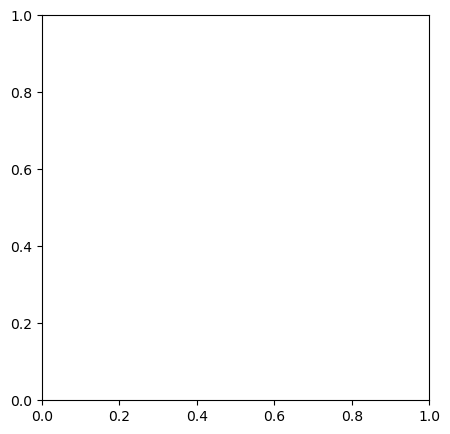

In [1]:
###### 绘制残差-拟合值图
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(1,1,1)
fittedvalues = model.fittedvalues 
resid = model.resid
ax1.scatter(fittedvalues,resid,color = 'blue',edgecolor = 'k',alpha=0.7)
ax1.axhline(y = 0 ,color = 'red',linestyle = '--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# 从图中看，残差分布较为均匀，且没有明显的异方差模式（如漏斗形状或系统性变化），所以可以认为该模型大体满足同方差性假设。
# 如果要进一步验证，也可以进行形式化的统计检验，例如：
# Breusch-Pagan 检验
# White 检验

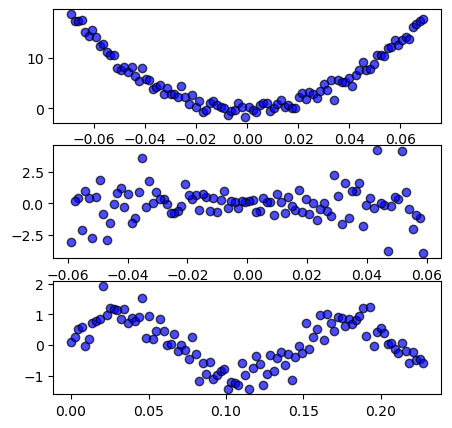

In [2]:
###### 附录具有模式的残差-拟合值图 这种代表不满足同方差性
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 重新生成数据
np.random.seed(42)
# (1) 曲线模式数据
x1 = np.linspace(-3, 3, 100)
y1 = 2 * x1**2 + np.random.normal(scale=1, size=100)
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(3,1,1)
model = sm.OLS(y1,x1).fit()
ax1.scatter(model.fittedvalues,model.resid,color = 'blue',edgecolor = 'k',alpha=0.7)


# (2) 漏斗模式数据
x2 = np.linspace(-3, 3, 100)
y2 = np.random.normal(scale=(0.5 + x2**2 / 4), size=100)
ax2 = fig.add_subplot(3,1,2)
model = sm.OLS(y2,x2).fit()
ax2.scatter(model.fittedvalues,model.resid,color = 'blue',edgecolor = 'k',alpha=0.7)


# (3) 波浪模式数据
x3 = np.linspace(0, 10, 100)
y3 = np.sin(x3) + np.random.normal(scale=0.3, size=100)
ax3 = fig.add_subplot(3,1,3)
model = sm.OLS(y3,x3).fit()
ax3.scatter(model.fittedvalues,model.resid,color = 'blue',edgecolor = 'k',alpha=0.7)
plt.show()


##### （二）决策树 DecisionTree
决策树降维的核心在于通过特征重要性（Feature Importance）来判断哪些特征对模型决策不重要甚至没有参与决策。   
特征重要性是通过决策树中每个特征在树的分裂中所带来的信息增益或不纯度减少来计算的。     
信息的混乱程度为熵，降低熵的数值即可达成信息增益 故而有如下的计算公式      

In [3]:
import pandas as pd
import numpy as np
import math

# 准备计算对于列联表的产物概率表 算熵的函数
def calculate_HY(row):
    hy = 0
    for posb in row.index:
        hy += row[posb] * math.log2(row[posb]   + 1e-9)

    return -hy

df = pd.DataFrame({'天气': ['晴朗','晴朗','阴天','阴天','雨天','雨天' ] ,'温度': ['高','高','中','低','中','低']  ,'下雨':['否','否','是','是','是','是']   }   )
# 算出原始概率
sp = df.下雨.value_counts()/len(df)
# 算出原始H(Y)
hy =  - sp @ np.log2(sp)# 向量算法  第一位*第一位 第二位*第二位 其实最终的结果会直接等于矩阵点积 所以我直接写了点积
print(f'原始的熵为:{hy}')

## 基于天气计算分组的熵
# 计算天气自身的概率
spweather = df.天气.value_counts()/len(df)

# 写一个函数 对列联表的概率值结果计算出他们对应的熵 H(Y|x)
dfcross = pd.crosstab(df['天气'],df['下雨'],normalize = 'index')  # normalize按行标准化 算出出现概率
dfcross['hy'] = dfcross.apply(calculate_HY,axis = 1) # 基于概率算出对应的熵 等于 - pi * log2(pi) h(y)
dfcross['spweather'] = spweather
hy_weather = dfcross.hy @ dfcross.spweather  # 分组的算法 H(Y|x) = ∑ p(x) * h(x)
print(hy_weather) # H(Y|X) 分组的熵 如果是 H(Y|X1,X2,……Xi) = 多特征交叉分组后的列联表算出多特征联合的分组 的概率 再基于概率算熵 最后走 p(x) * h(x)的形式算出多分组
print(f'天气分组后的熵为:{hy_weather}')

# 计算信息增益
# IG(D,天气)=H(D)−H(D∣天气)≈0.918−0.3=0.618
print(f'信息增益{hy - hy_weather}')  # 此时信息增益基本等于 原始熵 说明这个特征基本是完成了对于是否下雨这个事情的解释


原始的熵为:0.9182958340544896
-1.4426951595367387e-09
天气分组后的熵为:-1.4426951595367387e-09
信息增益0.9182958354971847


In [ ]:
# 其他快速完成列联表 计算的写法一
df.groupby(['天气','温度']).agg(是 = ('下雨', lambda x : (x == '是').sum()  ) ,
                               否 = ('下雨', lambda x : (x == '否').sum()  ) ,
                               总体计数 = ('下雨', 'count' )
                           ) 

# 如果多特征分许可以写成 [df['天气'], df['温度'] 
# pd.crosstab([df['天气'], df['温度']   ]  ,df['下雨'])

In [ ]:
from sklearn.tree import DecisionTreeClassifier,export_graphviz
import graphviz

df = pd.DataFrame({'天气': ['晴朗','晴朗','阴天','阴天','雨天','雨天' ] ,'温度': ['高','高','中','低','中','低']  ,'下雨':['否','否','是','是','是','是']   }   )
df = pd.DataFrame({'天气': ['0','0','1','1','2','2' ] ,'温度': ['2','2','1','0','1','0']  ,'下雨':['0','0','1','1','1','1']   }   )


tree = DecisionTreeClassifier()
Xs = df.drop(columns = ['下雨'])
y  = df.下雨
tree.fit(Xs,y)
print(tree.classes_)
print(tree.feature_importances_)

dot = export_graphviz(decision_tree = tree, feature_names = Xs.columns, class_names =['不下雨','下雨'],
                     filled = True, rounded = True, special_characters =True
                     )
gra = graphviz.Source(dot)
print(gra)

# 补充说明gini不纯度概念
# Gini不纯度 Gini指标的值范围在0到1之间，值越小表示数据集越纯净，即样本越集中于某一类。
# Gini(D) = 1 – Σ(p_i)^2  p_i 是指每一类在这个叶子的样本中出现的概率 
# 假设一个数据集包含三类样本，分别占比30%、40%和30%，其Gini指标计算如下：
# 计算每一类样本的平方：0.3^2 = 0.09, 0.4^2 = 0.16, 0.3^2 = 0.09。
# 求和：0.09 + 0.16 + 0.09 = 0.34。
# 计算Gini指标：1 – 0.34 = 0.66。

##### （三）随机森林 RandomForest
随机森林将随机的采取众多决策树（弱分类器 弱预测器） 并将多个树预测的结果合并到最终结果值中，比直接采取1棵决策树（强预测器）会更加稳妥    
但是其作为数据降维的底层逻辑和决策树是完全一致的 就是看特征被采用的次数             
因此弱点和决策树也是完全一致的，那就是不排除特征不被采用是因为决策树/随机森林没能捕获到其特性

In [4]:
### 随机森林拟合
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
df = pd.read_csv(r"D:\1-script\3-PYTHON\data存储jupyter用的个文件类型数据\Hands-On-Data-Preprocessing-in-Python-main\Chapter13\Customer Churn.csv")
Xs = df.drop(columns = ['Churn'])
y  = df.Churn
ran_forset = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth=None,min_samples_split =2,min_samples_leaf=1,
                                    max_features = 'sqrt', # 限制每个节点分裂时考虑的特征数量 不会给你全部的特征去计算
                                    bootstrap=True , # 默认就是启动的 自助法（Bootstrap Sampling）是一种重抽样方法。它通过从原始训练集随机抽取样本（有放回抽样）来创建多个子集。没被抽中的就是袋外样本
                                    verbose = 1, # 1 或更高的值表示输出详细的训练过程信息，包括树的构建进度等。这对于调试和监控模型训练过程非常有用。0就不输出
                                   )
ran_forset.fit(Xs,y)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


RandomForestClassifier(criterion='entropy', verbose=1)

<Axes: >

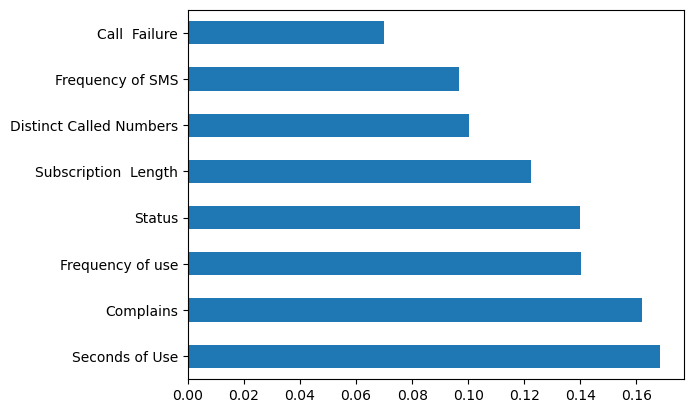

In [5]:
## 拟合完成后打印出 特征重要度 图
Xs_import = pd.Series(ran_forset.feature_importances_, index = Xs.columns)
Xs_import.sort_values(ascending = False).plot.barh()

In [ ]:
## 可调用随机森林中的某一棵树木来绘图
from sklearn.tree import plot_tree,export_graphviz
import graphviz
print(type(ran_forset.estimators_[0]))
tree = ran_forset.estimators_[0]
dot = export_graphviz(decision_tree = tree, feature_names = Xs.columns, class_names = ['Not Churn','Churn'],
                     filled = True, rounded = True, special_characters =True)
gra = graphviz.Source(dot)
gra

In [ ]:
## 附录访问随机森林的一些其他 常用方法
print(ran_forset.classes_)
print(ran_forset.feature_importances_)
print(ran_forset.estimators_)
print(ran_forset.n_estimators)
print(ran_forset.n_classes_)

##### （四）暴力降维计算 brute-force computational dimension reduction
尝试所有特征组合 即可知道最优解法 代价是计算成本太高 优点是通解

In [ ]:
import pandas as pd
import itertools
from sklearn.metrics import recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import time

# 计算开始时间
start_time = time.time()

# 读取数据并归一化
df = pd.read_csv(r"D:\1-script\3-PYTHON\data存储jupyter用的个文件类型数据\Hands-On-Data-Preprocessing-in-Python-main\Chapter13\Customer Churn.csv")
df_std = ( df-df.min() ) / ( df.max()-df.min() )

# 获取特征长度和列表
atts = df.drop(columns = ['Churn']).columns
n_atts = len(atts)

# 预留一个空的用于准备装填 暴力计算加网格搜索的结果
df_bforce_result = pd.DataFrame(columns = ['att_combined','best_k','performance'])

# 开始暴力计算
for n in range(1, n_atts + 1):
    for att in itertools.combinations(atts,r=n):  # 从1-8 组合所有特征组
        print(f'本次尝试的特征组合是：{att}')
        Xs = df_std[list(att)] 
        y  = df.Churn

        # 执行网格搜索
        param_grid = {'n_neighbors':[1,3,5,7]}
        gscv = GridSearchCV(KNeighborsClassifier(),param_grid,cv = 2,scoring = 'recall')
        gscv.fit(Xs,y)
        best_params = gscv.best_params_['n_neighbors']
        # print(gscv.cv_results_)
        
        # 找到最优参数的评估模型 用于预测
        knn = gscv.best_estimator_  # knn = KNeighborsClassifier(best_params)          knn.fit(Xs,y)   等价于这两句话
        y_predict = knn.predict(Xs)
        df_bforce_result_part = pd.DataFrame({'att_combined':[att], 'best_k':best_params, 'performance': recall_score(y,y_predict) })
        df_bforce_result = pd.concat([df_bforce_result,df_bforce_result_part],ignore_index = True)

# 计算开始时间
end_time = time.time()
delta = start_time - end_time
print(f'合计消耗{delta}秒')

In [ ]:
# df_bforce_result.to_csv(r"C:\Users\yaoyan\Downloads\暴力计算.csv")
df_bforce_result = df_bforce_result.sort_values(['performance'],ascending = False)
df_bforce_result.to_csv(r"C:\Users\yaoyan\Downloads\暴力计算.csv")

In [ ]:
#### 附录 itertools 的效果 可打印出全部组合 并检查组合数量与上方输出的结果是否行数一致
i = 0 
for n in range(1, n_atts + 1):
    for att in itertools.combinations(atts,r=n):  # 从1-8 组合所有特征组
        i += 1

##### （五）主成分分析 principal component analysis PCA 
最通用的非参数降维方法 涉及的线性代数的坐标轴变化     
所以仅在假设数据集的特性形成线性关系 PCA基本就是通用的非参数降维 反之如果存在非线性关系 则应该尽量避免使用PCA     

In [ ]:
## 引入toy 玩具数据集 用于解释方法
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_excel(r"D:\1-script\3-PYTHON\data存储jupyter用的个文件类型数据\Hands-On-Data-Preprocessing-in-Python-main\Chapter13\PCA_toy_dataset.xlsx")
df.info
df.head(5)

## 查看总体方差
dfvar =pd.DataFrame( {'方差统计':df.var()})
dfvar = pd.concat(   [   dfvar,   pd.DataFrame( {'方差统计':dfvar.sum()})   ]    )
dfvar.index = ['Dimension_1', 'Dimension_2', 'Total']
print('数据集方差情况如下\n', dfvar, '\n')

## 查看特征相关性情况
print('数据集相关性情况如下\n',df.corr() , '\n') # 皮尔逊相关系数

## 绘画特征散点图
print('数据集散点图情况如下\n')
plt.scatter(df.Dimension_1,df.Dimension_2)
plt.show()

In [ ]:
#### 对于 PCA 来说 数据集携带的信息量大小就是方差总和 即 1026.989474 
## PCA 具有数据的非参数视图，特性仅仅只是数字变化形式信息的持有者；PCA认为它合适转化数据，使得维度不呈现出相似的信息
## 使用sklearn库完成转化

from sklearn.decomposition import PCA
pca = PCA()
pca.fit(df)
df = pd.DataFrame(pca.transform(df),columns = ['PCA1','PCA2'] )  # 可以简写为(pca.fit_transform(df) 这样 pca.fit(df) 可以省略


## 查看总体方差 # Total  1026.989474  这个数值未改变 所以PCA不会增加特征携带的信息 只是将信息从一个特征转移到另一个
dfvar =pd.DataFrame( {'方差统计':df.var()})
dfvar = pd.concat(   [   dfvar,   pd.DataFrame( {'方差统计':dfvar.sum()})   ]    )
dfvar.index = ['PCA1', 'PCA2', 'Total']
print('数据集方差情况如下\n', dfvar, '\n')  

## 查看特征相关性情况  # 相关性趋近于0 意味着两个特征批充正交 想象
print('数据集相关性情况如下\n',df.corr() , '\n') # 皮尔逊相关系数

## 绘画特征散点图 # 旋转未PCA前的特征 可以发现两者具有相似性
print('数据集散点图情况如下\n')
plt.scatter(df.PCA1,df.PCA2)
plt.show()


#### 补充关于正交
## 正交的定义
# 向量正交：在向量空间中，两个向量 
# a 和 b 被称为正交，如果它们的点积（内积）为零：
# 𝑎⋅𝑏=0
# 这意味着这两个向量在几何上是垂直的。

# ## 函数正交：
# 在函数空间中，两个函数 
# f(x) 和 g(x) 被称为正交，如果它们在某个区间的内积为零：

# 这表示这两个函数在该区间上没有重叠部分，类似于向量的垂直性。
# 正交性质常用于图形学和信号处理等领域，帮助简化计算和分析。

In [1]:
#### 正式的数据集演示PCA
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


## 禁用科学计数法，设置浮点数格式
pd.set_option('display.float_format', '{:.2f}'.format)

## 准备具有超多特征的数据集
df = pd.read_csv(r"D:\1-script\3-PYTHON\data存储jupyter用的个文件类型数据\Hands-On-Data-Preprocessing-in-Python-main\Chapter13\WH Report_preprocessed.csv")
country_df = df.pivot(index = 'Name',columns = 'year',values = ['Life_Ladder',
       'Log_GDP_per_capita', 'Social_support',
       'Healthy_life_expectancy_at_birth', 'Freedom_to_make_life_choices',
       'Generosity', 'Perceptions_of_corruption', 'Positive_affect',
       'Negative_affect'])
Xs = country_df

## 执行标准化  关注方差的PCA容易被过大的方差吸引去注意力 所以必须先标准化
# 方法一
stdsca = StandardScaler()  # 默认采用的总体的标准差 作为分母 而非样本的标准差作为分母
Xs_std1 = pd.DataFrame(stdsca.fit_transform(Xs), columns = Xs.columns,index = Xs.index)

# 方法二
Xs_std2 = ((Xs - Xs.mean() )/Xs.std(ddof = 1)) # 教材计算的时候采取了样本标准差 下面保持一致

## 执行PCA主成分分析
pca = PCA()
Xs_std_pca = pd.DataFrame(data = pca.fit_transform(Xs_std2), index = Xs_std2.index)
Xs_std_pca.columns = [f'PCA{i}' for i in range(1,len(Xs_std2.columns) + 1)]

## 执行累计方差解释分析
df_cumulative_variance_explanation_analysis = pd.DataFrame( {'every_var_of_X': Xs_std_pca.var(), 
               'cum_every_var_of_X': Xs_std_pca.var().cumsum() ,
               'total_var' : Xs_std_pca.var().sum().sum(),
               'percentage_cum_every_var_of_X' :Xs_std_pca.var().cumsum() /Xs_std_pca.var().sum().sum()} )
df_cumulative_variance_explanation_analysis   ## 三个特征就解释了71%的变化 换成PCA前 需要64个特征才能解释 71%变化 （64/90）

,every_var_of_X,cum_every_var_of_X,total_var,percentage_cum_every_var_of_X
PCA1,42.98,42.98,90.00,0.48
PCA2,14.49,57.47,90.00,0.64
PCA3,6.48,63.95,90.00,0.71
PCA4,6.15,70.10,90.00,0.78
PCA5,4.76,74.86,90.00,0.83
...,...,...,...,...
PCA86,0.00,90.00,90.00,1.00
PCA87,0.00,90.00,90.00,1.00
PCA88,0.00,90.00,90.00,1.00
PCA89,0.00,90.00,90.00,1.00


In [4]:
Xs_std2.var()

                 year
Life_Ladder      2010   1.00
                 2011   1.00
                 2012   1.00
                 2013   1.00
                 2014   1.00
                        ... 
Negative_affect  2015   1.00
                 2016   1.00
                 2017   1.00
                 2018   1.00
                 2019   1.00
Length: 90, dtype: float64

In [ ]:
## 理解累计方差解释分析中前三项目 的重要性占比概念
前三项特征的方差总和 = df_cumulative_variance_explanation_analysis.loc['PCA3','cum_every_var_of_X']
前三项特征的每个特征的方差 = df_cumulative_variance_explanation_analysis.loc['PCA1':'PCA3' , 'every_var_of_X']
前三项特征的每个特征的方差占比方差贡献的比例 = 前三项特征的每个特征的方差/前三项特征的方差总和
print(前三项特征的每个特征的方差占比方差贡献的比例)

## 理解PCA1-PCA3三项目特征的取值范围 用于后续优化绘图时对比查看
print(pd.DataFrame( {'min':Xs_std_pca.min(), 'max':Xs_std_pca.max()} ) )

## 三维散点图绘画
Xs_std_pca.plot.scatter(x = 'PCA1',y = 'PCA2' ,c = 'PCA3',sharex = False,cmap = 'gray_r',)

In [ ]:
#### 三维散点图绘画优化
## 1 优化了 颜色展示的时候设置上下限为更大 还原了极限值点的真实颜色  ； 并且放大了图片
Xs_std_pca.plot.scatter(x = 'PCA1',y = 'PCA2' ,c = 'PCA3',sharex = False ,
                        cmap = 'gray_r', vmin  =-1/0.101, vmax = 1/0.101,  # 极限值点的真实颜色
                        figsize = (12,9) # 扩大图
                       )

## 2 绘制x网格线 和重设坐标
# 制作新的x刻度线 并且用于网格线绘制
x_ticks_vs = [-2.9*4 + 2.9 * i for i in range(9)] # 基于特征贡献占比的 PCA1   0.67  1/0.67 = 1.4 *2  =2.9
# 绘制网格线
for v in x_ticks_vs:
    plt.axvline(v,c ='gray', linestyle = '--', linewidth = 0.5)
# 重设x的刻度坐标
plt.xticks(x_ticks_vs)

## 3 绘制y网格线 和重设坐标
y_ticks_hs = [-8.7, 0, 8.7]
# 绘制网格线
for h in y_ticks_hs:
    plt.axhline(h,c ='gray', linestyle = '--', linewidth = 0.5)
# 重设y的刻度坐标
plt.yticks(y_ticks_hs)

## 4 增加点对应的国家名称 随机抽取50个 避免过分混乱
for country_name,row in Xs_std_pca.sample(50).iterrows():
    plt.annotate(country_name,(row.PCA1,row.PCA2),rotation = 50,c = 'gray',size = 8)  # rotation 旋转 用于转50度
plt.show()

##### （六）函数型数据分析 functional data analysis FDA
找到一个数学函数 在可接受的程度上模仿数据       
找得到就能用 找不到就不能用          
FDA可以是一个独立的分析工具  也可以用于降维或者数据转换

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

#### 依旧采取5 主成分分析法使用过的 country_df

## 制造country_df
df = pd.read_csv(r"D:\1-script\3-PYTHON\data存储jupyter用的个文件类型数据\Hands-On-Data-Preprocessing-in-Python-main\Chapter13\WH Report_preprocessed.csv")
country_df = df.pivot(index = 'Name',columns = 'year',values = ['Life_Ladder',
       'Log_GDP_per_capita', 'Social_support',
       'Healthy_life_expectancy_at_birth', 'Freedom_to_make_life_choices',
       'Generosity', 'Perceptions_of_corruption', 'Positive_affect',
       'Negative_affect'])

## 根据9个幸福指数索引 绘画其对应的时间序列图
happiness_index = ['Life_Ladder',
       'Log_GDP_per_capita', 'Social_support',
       'Healthy_life_expectancy_at_birth', 'Freedom_to_make_life_choices',
       'Generosity', 'Perceptions_of_corruption', 'Positive_affect',
       'Negative_affect']

## 演示函数具有线性特征
# for name,row in country_df.iterrows():
#     for h_i in happiness_index:
#         print(row[h_i])
#         plt.plot(row[h_i])
#         plt.title(f'{name} - {h_i} ')
#         plt.show()
        


In [ ]:
#### 用样本数据执行拟合
## 我抽样了阿富汗的 生活阶梯数据 用这个数据来尝试拟合一个函数
df_sample = country_df.loc['Afghanistan','Life_Ladder']
df_sample.index = df_sample.index.astype('str')

## 根据绘图 我们可见存在线性相关
plt.plot(df_sample,label = 'data')

## 选用一元回归函数 时间序列可以简单为时间的由小到大 0-9的数字
# y = bo + b1 * x1 此时x1即为时间序列的t
x = np.array([0,1,2,3,4,5,6,7,8,9])
y = df_sample.values
# 计算协方差
print( f'手动计算的协方差为 {np.sum( (x - x.mean()  ) * (y - y.mean() ) )  / len(x) }')
cov_matrix = np.cov(x,y,ddof = 0) # 默认算样本 此处需要补充ddof = 0算总体
cov_xy = cov_matrix[0, 1]  # 获取协方差值
print(f'np.cov取[0,1]算出来的协方差为{cov_xy}')
# 计算协方差/方差 拿到斜率
b1 = cov_xy / x.var(ddof = 0)  # 一元回归的b1系数
# 基于斜率计算截距
b0 = y.mean() - x.mean() * b1 
print(f'\n一元回归公式拟合结果为 y = {b0}+{b1} * x')
# 然后将其准备为函数
def linearfunction(x,b0,b1):
    y = x * b1 + b0
    return y 

## 对于你制造的拟合函数评估下
# R2和adjR2分数
y_predict =np.array([ linearfunction(t,b0,b1)  for t in x ])
RSS = np.sum( (y_predict - y) ** 2)
TSS =np.sum(  (y - y.mean())   **2)
R2 = 1 - RSS/TSS
print(f'\n手动计算R2评价分数的结果为{R2}')
from sklearn.metrics import r2_score
print(f'r2_score 算出来的 结果为 {r2_score(y,y_predict)} ')
dof_res = len(x) - 1 - 1
ADJR2 = 1 - (RSS/dof_res) / (TSS/(len(x) - 1))
print('手动计算的调整后的r2分数为{ADJR2}')

## 原有图片上拟合出一条预测线
print('\n拟合回归线如下')
plt.plot(df_sample.index,y_predict,'--',label = 'fit')
plt.legend()
plt.show()

In [ ]:
#### 进一步封装一个函数 审核所有样本在9个幸福指数下的评估结果
## 根据绘图 我们可见存在线性相关
def estimator_linear(df_sample):
    plt.plot(df_sample,label = 'data')
    
    ## 选用一元回归函数 时间序列可以简单为时间的由小到大 0-9的数字
    # y = bo + b1 * x1 此时x1即为时间序列的t
    x = np.array([0,1,2,3,4,5,6,7,8,9])
    y = df_sample.values
    # 计算协方差
    print( f'手动计算的协方差为 {np.sum( (x - x.mean()  ) * (y - y.mean() ) )  / len(x) }')
    cov_matrix = np.cov(x,y,ddof = 0) # 默认算样本 此处需要补充ddof = 0算总体
    cov_xy = cov_matrix[0, 1]  # 获取协方差值
    print(f'np.cov取[0,1]算出来的协方差为{cov_xy}')
    # 计算协方差/方差 拿到斜率
    b1 = cov_xy / x.var(ddof = 0)  # 一元回归的b1系数
    # 基于斜率计算截距
    b0 = y.mean() - x.mean() * b1 
    print(f'\n一元回归公式拟合结果为 y = {b0}+{b1} * x')
    # 然后将其准备为函数
    def linearfunction(x,b0,b1):
        y = x * b1 + b0
        return y 
    
    ## 对于你制造的拟合函数评估下
    # R2和adjR2分数
    y_predict =np.array([ linearfunction(t,b0,b1)  for t in x ])
    RSS = np.sum( (y_predict - y) ** 2)
    TSS =np.sum(  (y - y.mean())   **2)
    R2 = 1 - RSS/TSS
    print(f'\n手动计算R2评价分数的结果为{R2}')
    from sklearn.metrics import r2_score
    print(f'r2_score 算出来的 结果为 {r2_score(y,y_predict)} ')
    dof_res = len(x) - 1 - 1
    ADJR2 = 1 - (RSS/dof_res) / (TSS/(len(x) - 1))
    print(f'手动计算的调整后的r2分数为{ADJR2}')
    
    ## 原有图片上拟合出一条预测线
    print('\n拟合回归线如下')
    plt.plot(df_sample.index,y_predict,'--',label = 'fit')
    plt.legend()
    plt.show()
    return R2

happiness_r2_dict = {h_i:[] for h_i in happiness_index}
for name,row in country_df.iterrows():
    for h_i in happiness_index:
        R2 = estimator_linear(row[h_i])
        happiness_r2_dict[h_i].append(R2)

In [ ]:
#### 对于基于封装函数收集到的每个模型的评估分数 查看下
## 将R2分数画为箱型图
import seaborn as sns
sns.boxplot(happiness_r2_dict)
plt.xticks(rotation = 90)
plt.show()

## 基于图得出结论
# 在LOG_GDP 和 healthy_life这两个特征上的曲线拟合的较为好 表明他们的线性趋势较为强大 
# 其他的幸福指数在线性拟合下效果并非非常理想 但是线性函数往往容易捕获到对分析很重要的本质 即使在拟合不佳的情况下 也能保留下趋势

In [ ]:
#### 执行最终的FDA转化
happiness_index = ['Life_Ladder',
       'Log_GDP_per_capita', 'Social_support',
       'Healthy_life_expectancy_at_birth', 'Freedom_to_make_life_choices',
       'Generosity', 'Perceptions_of_corruption', 'Positive_affect',
       'Negative_affect']
ml_index = pd.MultiIndex.from_product([happiness_index,['b0','b1'] ],names = ['Happiness Index', 'Parameter'])

## 定义一个对于每行的每个幸福指数都执行计算的函数
def linear_function(x,y):
    cov_xy = np.sum( (x - x.mean()  ) * (y - y.mean() ) )  / len(x) 
    b1 = cov_xy / x.var(ddof = 0)  # 一元回归的b1系数
    # 基于斜率计算截距
    b0 = y.mean() - x.mean() * b1 
    return b0,b1

## 定义一个apply用的向量化计算函数 对于每一行 循环每个幸福指数 压缩其10年的信息 为2个变化信息 截距和斜率 截距代表起始的幸福指数高低 斜率代表是向上还是向下 快速还是慢速
def FDA_Linear_Transform(row):
    fda_series = pd.Series(data = np.nan, index = ml_index)
    for h_i in happiness_index:
        Xs = np.array(range(10))
        y  = row[h_i]
        b0,b1 = linear_function(Xs,y)
        fda_series.loc[h_i,'b0'] = b0
        fda_series.loc[h_i,'b1'] = b1
    return fda_series

## 对于初始的特征数据集 执行降维操作 转化为FDA搭配线性函数的 系数信息
country_df.apply(FDA_Linear_Transform,axis = 1)

## 总结对比 PCA和FDA
# 特征数量上和信息保留程度上 PCA可以用3个特征完成71%的信息保留 ； FDA则需要用18个特征保留信息 但是不确定信息的损失度
# 参数化理解的便利性 ： PCA 是较难解释的 ； FDA的系数存在明确的含义 截距代表起始的幸福指数高低 斜率代表10年内变化情况是向上还是向下 快速还是慢速
# PCA无法指定变化类型 ； FDA具有自定义使用的变化类型 比如本案例因为结合的是线性回归函数 其系数就是截距 和 斜率了

##### （七）关于scipy.optimize.curve_fit
关于scipy 是一个广泛用于科学 统计 计算领域的开源库 基于numpy搭建的     
其下存在的主要模块（线性代数，优化，插值，信号处理，统计分布，数值积分和微分中 ） 我们过去为了做假设检验解除最多是 统计分布 stats     
现在看到的这个optimize 优化 其主要用途是在约束条件下 寻找最优解     
curve_fit curve fitting 曲线拟合就是典型的 一个约束条件下的 寻找参数最优解 使得拟合的曲线预测的数据点和实际的数据点 相差尽量减小的一个函数    

1. 介绍curve_fit

In [ ]:
####  curve fitting 曲线拟合的参数
from scipy.optimize import curve_fit
curve_fit??
## 参数解释
# f  格式为f(x, *params) 定义一个python函数 params是此函数的系数
# xdata  自变量数据（独立变量），可以是一个数组或列表。
# ydata  因变量数据（依赖变量），与 xdata 具有相同的长度。
# p0    可选，初始参数猜测。应该是一个数组，其长度与函数 f 的参数数量一致。提供合理的初始值可以提高拟合的成功率
# sigma 可选，ydata 的标准差，用于加权拟合。如果提供，函数会使用这些标准差来加权最小二乘法。
# absolute_sigma  可选，布尔值，表示 sigma 是否是绝对误差。默认为 False，表示 sigma 是相对误差。
# bounds 可选，参数的边界（最小值和最大值），可以是一个元组，格式为 (min, max)。可以用 -np.inf 或 np.inf 表示无穷大。
# method 可选，指定优化方法，默认为 'lm'（Levenberg-Marquardt）。其他方法包括 'trf' 和 'dogbox'。
# L-M方法全称Levenberg-Marquardt方法，是非线性回归中回归参数最小二乘估计的一种估计方法。由D.W.Marquardt于1963年提出，他是根据1944年K.Levenbevg的一篇论文发展的。这种方法是把最速下降法和线性化方法(泰勒级数)加以综合的一种方法。因为最速下降法适用于迭代的开始阶段参数估计值远离最优值的情况，而线性化方法，即高斯牛顿法适用于迭代的后期，参数估计值接近最优值的范围内。两种方法结合起来可以较快地找到最优值 [1]。

2. curve_fit作用于线性函数

In [ ]:
#### 线性函数 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## 准备使用的数据集
df = pd.read_csv(r"D:\1-script\3-PYTHON\data存储jupyter用的个文件类型数据\Hands-On-Data-Preprocessing-in-Python-main\Chapter13\WH Report_preprocessed.csv")
country_df = df.pivot(index = 'Name',columns = 'year',values = ['Life_Ladder',
       'Log_GDP_per_capita', 'Social_support',
       'Healthy_life_expectancy_at_birth', 'Freedom_to_make_life_choices',
       'Generosity', 'Perceptions_of_corruption', 'Positive_affect',
       'Negative_affect'])
df_sample = country_df.loc['Afghanistan','Life_Ladder']
df_sample.index = df_sample.index.astype('str')

## 对于一个时间序列的函数 其x等于 0-年的上限 也即是9
Xs = range(10)
y  = df_sample.values

## 定义一个线性函数
def linear_function(x,b0,b1):
    y = b0 + b1 * x
    return y

## 开始拟合
拟合参数,参数的协方差矩阵 = curve_fit(linear_function,Xs,y) 
print(拟合参数)
print(参数的协方差矩阵)
# 拟合参数 对于这个案例就是第一个对应b0 第二个对着b1  和你公式里面系数的顺序保持一致的
# 协方差矩阵的解读 对角线上的元素是每个参数的方差  较小的方差值表明参数的估计更为精确。
               # 非对角线上的元素（如 -0.01457163）表示参数之间的协方差，反映了一个参数的变化如何影响另一个参数的变化。 如果协方差接近于0，说明两个参数之间的关系较弱；如果协方差绝对值较大，说明两个参数可能相关。相关的参数代表多重共线性问题

3. curve_fit作用于指数函数

In [ ]:
#### 指数函数 非线性的表现之一

## 什么是指数计算
# 指数计算是数学中一个基本的运算，涉及将一个数（基数）提升到另一个数（指数）的幂。它可以表示为： a的b次方 a是基数（底数） b 是指数，表示将基数乘以自身的次数 
# python中使用 np.power(底数,指数) 计算任意数 numpy.exp() 计算自然指数（以𝑒为底的指数）
import numpy as np
np.power(2,3)
np.power(3,2)
np.exp(1) 
# python中使用 math库 也可做计算 上下3个计算是完全相等的
import math
math.pow(2,3)
math.pow(3,2)
math.exp(1)
# 指数运算的基本数学规则
math.pow(2,1) # a ** 1 = a
math.pow(2,0) # a ** 0 = 1
math.pow(2,-1) ==  1 / math.pow(2,1)   # a ** -b =  1 / a ** b 
math.pow(2,11) ==  1 / math.pow(2,-1)  # a ** -b =  1 / a ** b 
math.pow(2,1) * math.pow(2,9)  == math.pow(2,10) # a ** m * a ** n  =  a ** (m+n)
math.pow(2,1) / math.pow(2,9)  == math.pow(2,-8) # a ** m / a ** n  =  a ** (m-n)
math.pow(2,7) ** 3 == math.pow(2,21)   # (a ** m ) ** n  =  a ** (m*n)
math.pow(2*3,6) == math.pow(2,6) * math.pow(3,6) # ab ** m = a ** m * b ** m

## 指数函数可以捕获以指数增长或衰减为特征的特征 指数是前期慢后期快速的一种函数
# y = a * (e ** (b * x))
def exponential_function(x,a,b):
    y = a * np.exp(b * x)
    return y

import numpy as np
import matplotlib.pyplot as plt
# 定义 x 范围
x = np.linspace(-2, 2, 100)
# 不同参数的示例
params = [(1, -2), (1, 2), (-1, -2), (-1, 2)]
# 绘制图形
plt.figure(figsize=(10, 6))
for a, b in params:
    y = exponential_function(x, a, b)
    plt.plot(x, y, label=f'a={a}, b={b}')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(0, color='black', lw=0.5, ls='--')
plt.title('Exponential Functions with Different Parameters')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.ylim(-5, 5)
plt.show()

# # 总结指数函数的结论 
# 当 a>0：b<0：随着 𝑥 的增加，𝑦 会减少，表现为指数衰减。
#         b>0：随着 𝑥的增加， 𝑦 会增加，表现为指数增长。
# 当 a<0：b<0： 随着 𝑥 的增加，𝑦 会增加，但值为负，表现为负的指数衰减。
#         b>0： 随着 𝑥 的增加， 𝑦 会减少，值也为负，表现为负的指数增长。

In [ ]:
#### 引入一个实际的案例查看下
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
df = pd.read_csv(r"D:\1-script\3-PYTHON\data存储jupyter用的个文件类型数据\Hands-On-Data-Preprocessing-in-Python-main\Chapter13\GoogleStock.csv")
df = df.set_index('t')
y  = df.Price
Xs = range(len(y))

def exponential_function(x,a,b):
    y = a * np.exp(b * x)
    return y
    
p,c = curve_fit(exponential_function,Xs,y,p0 = [df.Price.min(),0])  # p0 代表我们认为的参数是如何的 有几个系数给几个值构成列表 为了使拟合更好 建议给出 这里第一个系数a 代表是x不动时的起始值 故取min 即首值 = a的1次方

y_predict = [exponential_function(x,p[0],p[1])  for x in Xs ]

R2 = 1 - np.sum(  (y_predict - y) **2 ) / np.sum(  (y - y.mean() ) **2 )  # R² 可用于线性和非线性模型，只要模型产生的预测值可以与实际数据进行比较。 当然 均方根误差（RMSE） 平均绝对误差（MAE） 调整后的 R² 也都可以使用

plt.plot(Xs, y , label = 'Stock Price DAY')
plt.plot(Xs, y_predict , '--' ,label = 'FIT')
plt.xticks(np.linspace(1, 4291, num=15,),y.iloc[1::300].index,rotation = 90 )
plt.legend()
plt.show()

4. curve_fit作用于正弦函数

In [ ]:
#### 正弦函数 非线性的表现之一

## python中使用 math.sin() math.cos()  np.sin()  np.cos() 计算 ; math.pi or np.pi 来获取较精确的pi值
# 什么是正弦函数  正弦函数是一个角度的函数，通常表示为 sin(𝑥) 其中 𝑥 是角度（以弧度或度数为单位）。在单位圆中，正弦值等于该角对应点的 𝑦 坐标。
# 什么是余弦函数  余弦函数是一个角度的函数，通常表示为 cos(𝑥) 其中 𝑥 是角度（以弧度或度数为单位）。单位圆中，余弦值等于该角对应点的 𝑥 坐标。

## 理解角度 理解弧度 一个完整的圆周（360度）等于 2π 弧度。在弧度上表示为2pi 故单弧度 pi可以换算为180°的角 
# 编程维度上 角度 通常换算为弧度执行计算 三角函数 ；转化公式为  radians = degrees * pi / 180   degrees = radians * 180 / pi  ； pi采用math.pi获取较为精确的值
# 无论什么圆 无论什么参数 基于函数特性 固定不变的是周期等于 2pi 

## 理解角频率
# 角频率 角频率 (𝜔)：表示单位时间内的角度变化量，通常以弧度/单位时间 (rad/单位时间) 为单位。
# 角频率 = 弧度/单位时间 因为完整的弧度为2pi   2pi/数据观察到的单位时间（时间序列的 天 小时 秒 ； 距离 米  ；样本数据  样本点  ） = 角频率

## 理解频率
# 频率(f) 表示每单位时间内发生的循环数·
# 频率(f)  = 1 / T 

## 举例角频率 和 频率 
# 我们可以通过绘图 折线图 或者 散点图 都可以看出波形的变动周期 假设观察到的周期T =25 天 完成一轮波动
# T = 25 频率(f) = 1/25 = 0.04 cycles/day 表示该波动在一天内大约发生 0.04 次循环 1代表循环1次
# 角频率 𝜔 = 2pi/25 = 0.2513 rad/day 表示波动一天内大约可变化  0.2513 弧度

import math 
import numpy as np
degree = 30   # 角度 
radian = degree * np.pi /180  # 1/6 个 pi  # 角度换算弧度 
degree = radian * 180 / np.pi # 弧度换算角度

## 正圆形 绘图 
# 当你从圆的原点出发，逆时针旋转一个角度 𝜃 , 代表你从 (1,0) 移动到 (r * cos(𝜃) ,r * sin(𝜃)) 新坐标 (x,y)可以依赖于 三角函数求解得到 
import numpy as np
import matplotlib.pyplot as plt
fig,axs = plt.subplots(2,2 ,figsize=(20, 20))
ax1,ax2,ax3,ax4 = axs.flatten()
r = 1  # 半径 
t,step = np.linspace(0,2 * np.pi ,100,retstep = True) # 为了抗锯齿 我们增设了等步长的100个弧度
y = np.sin(t) * r 
x = np.cos(t) * r  # 对于一个椭圆形 说明x和y的半径不同 这里你多乘以个2就会发现变成椭圆
ax1.plot(x,y)
ax1.axis('equal')   # 确保 x 和 y 轴的比例相同
ax1.axhline(0,c ='gray', linestyle = '--', linewidth = 0.5)
ax1.axvline(0,c ='gray', linestyle = '--', linewidth = 0.5)
# 当你转换到模拟波段的时候 x坐标的值 通常固定为步长相等的 数组 比如 [0,1,2,3,4,5,6……] 其含义为周期 T T基于b算出 公式见下
# 此时你的波峰波谷的高度 就是y坐标的高度 控制其高度的就是 半径 就是你正选函数中的系数 a1  而非特征x的值 

## 一个常见的正弦函数公式 
def sinusoidal_function(x,a1,b1,c1,d1):
    y = a1 * np.sin(b1 * x + c1) + d1
    return y
# 对于系数的解释 
# a1 是振幅   振幅用于控制波的高度 绝对值越大 越是波峰波谷越高 ；负数则代表波形在垂直方向反转（即正弦波的峰值变为谷值，谷值变为峰值）
# b1 是角频率 可以反映出周期性 其余周期T的关系为 T= 2pi / abs(b)   𝑏值越大，周期越短，波形重复得越快；反之，𝑏值越小，周期越长，波形重复得越慢 
# c1 相位 ：影响波形在 𝑥 轴上的起始位置
# d1 垂直位移 : 将波形在 𝑦 轴上平移 𝑑 个单位

## 模拟每个参数变化绘画出不同的图对比认知参数的作用
# 组1 
a1 = 3
b1 = 0.5
c1 = 0
d1 = 0
T = 2*np.pi /0.5 # 确保周期完整
x1 = np.linspace(0,round(T+1,0),60) 
y1 = sinusoidal_function(x1,a1,b1,c1,d1)
ax3.plot(x1,y1,label = 'a = 3 b = 0.5')
ax4.plot(x1,y1,label = 'a = 3 b = 0.5 c=0')

# 组2 
a1 = 10
b1 = 0.5
c1 = 0
d1 = 0
T = 2*np.pi /0.5 # 确保周期完整
x2 = np.linspace(0,round(T+1,0),60) 
y2 = sinusoidal_function(x2,a1,b1,c1,d1)
ax3.plot(x2,y2,label = 'a = 10 b =0.5 ')

# 组3
a1 = 3
b1 = 2
c1 = 0
d1 = 0
T = 2*np.pi /0.5 # 确保周期完整
x3 = np.linspace(0,round(T+1,0),60) # 30个样本值 还能看出一定的锯齿感 
y3 = sinusoidal_function(x3,a1,b1,c1,d1)
ax3.plot(x3,y3,linestyle = '--',label = 'a = 3 b = 2')

# 组4 
a1 = 3
b1 = 0.5
c1 = 2
d1 = 0
T = 2*np.pi /0.5 # 确保周期完整
x4 = np.linspace(0,round(T+1,0),60) 
y4 = sinusoidal_function(x1,a1,b1,c1,d1)
ax4.plot(x4,y4,label = 'a = 3 b = 0.5 c = 2' )

# 组5
a1 = 3
b1 = 0.5
c1 = 0
d1 = 2
T = 2*np.pi /0.5 # 确保周期完整
x5 = np.linspace(0,round(T+1,0),60) 
y5 = sinusoidal_function(x1,a1,b1,c1,d1)
ax4.plot(x5,y5,label = 'a = 3 b = 0.5 d = 2' )

ax3.axis('equal') 
ax3.legend()
ax3.set_title('vs a & b ')  # 重点观察下 a和b变化造成的曲线变化 保持c和d不变
ax4.axis('equal') 
ax4.legend()
ax4.set_title('vs c & d ') # 重点观察下 c和d变化造成的曲线变化 保持a和b不变
plt.show()

In [ ]:
print(y1.min())
print(y1.max())
print(y5.min())
print(y5.max())

In [ ]:
#### 引入一个实际的案例拟合试下 正弦函数是处理噪声 和 语音数据 的 次级候选 
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

## 准备下案例数据
df = pd.read_csv(r"D:\1-script\3-PYTHON\data存储jupyter用的个文件类型数据\Hands-On-Data-Preprocessing-in-Python-main\Chapter13\Noise_data.csv")
y = df.Signal
x = np.array(range(len(y)))

def sin_function(x,a1,b1,c1,d1):
    y = a1 * np.sin(b1 * x + c1) +d1
    return y

## 详细解释下每个参数的算法
# 绘图观察变动趋势
plt.figure(figsize=(20, 6))
plt.plot(x,y,label = 'Noise Data')  # 有鉴于正弦函数的复杂性 我建议你观察下下面的图 找出合适的p0


# a1 振幅 观察数据的最大值和最小值，振幅是这两个值的差的一半
a1 = ( y.max() - y.min() )  /  2

# b1 角频率 观察数据是否存在周期性 然后基于 2pi/T 来计算
b1 = 2 * np.pi / 25   # （将周期转换为角频率） 25是绘画散点或者折现能一眼看出来的期数 当然高级的方法也有

# c1 相位 可以根据数据的起始位置进行估计
# c1 如果数据从波动的中间开始采取 0 值
# c1 如果数据从波动的上升段开始 则取值在 -pi 到  0 
# c1 如果数据从波动的下降段开始 则取值在  0  到 pi
# 对于这份数据 显然他在下降段 取正数  当然不按照这个来也不影响啥  收敛算法中最为要紧的是 周期和振幅
y_sorted = np.sort(y)
c1 = -np.where(y_sorted == y[0])[0][0] / len(y) * np.pi
# c1 = 0  #给0值也能正常收敛

# d1 偏移 可以通过数据的平均值来估计
d1 =  y.mean()

# 将系数带入拟合中
p,c = curve_fit(sin_function,x,y,p0 = [ a1,b1,c1,d1] )  #  [1000,0.25,2.5]
a1,b1,c1,d1 = p
print(f'f拟合的系数为{a1,b1,c1,d1}')

# 基于拟合系数 计算R2评分
y_predict = sin_function(x,a1,b1,c1,d1)
RSS = np.sum( (y_predict - y) ** 2)
TSS =np.sum(  (y - y.mean())   **2)
R2 = 1 - RSS/TSS
print(f'\n手动计算R2评价分数的结果为{R2}')
from sklearn.metrics import r2_score
print(f'r2_score 算出来的 结果为 {r2_score(y,y_predict)} ')

# 绘画
plt.plot(x,y_predict,linestyle = '--' , label = 'fit')
plt.legend()
plt.show()

In [ ]:
#### 补充实战案例中角频率 b1 系数 具体的 科学算法
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# 假设已加载数据 x 和 y
df = pd.read_csv(r"D:\1-script\3-PYTHON\data存储jupyter用的个文件类型数据\Hands-On-Data-Preprocessing-in-Python-main\Chapter13\Noise_data.csv")
y = df.Signal
x = np.array(range(len(y)))

# 绘制散点图
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(x, y, marker='o', linestyle='None')
plt.title('Data Scatter Plot')

# 自相关分析
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(y, lags=40, ax=plt.gca())
plt.title('Autocorrelation Function')

# 进行傅里叶变换
yf = np.fft.fft(y)
xf = np.fft.fftfreq(len(y), (x[1] - x[0]))

# 绘制傅里叶变换的幅度谱
plt.subplot(2, 1, 2)
plt.plot(xf[:len(x)//2], np.abs(yf)[:len(y)//2])
plt.title('Fourier Transform Magnitude Spectrum')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()

# 从频谱中找到主频率并计算周期
dominant_frequency = xf[np.argmax(np.abs(yf)[:len(y)//2])]
period = 1 / dominant_frequency if dominant_frequency != 0 else None
b1 = 2 * np.pi / period
print(f"估计的角频率为: {b1}")

5. curve_fit作用于高斯函数

In [ ]:
#### 高斯函数 
## 该函数以概率和统计中的高斯分布（也称为正态分布）而闻名 它的形式是一个钟形曲线，具有对称性和快速衰减的特性。
## 参数分别为 a μ σ
# a 振幅（函数的最大值）
# μ：均值（函数的中心位置） 不是算是意义上的平均值 而是指代最大值位于数据集中的索引位置  np.argmax(y) 获取最大值索引值
# σ：标准差（控制函数的宽度，σ 越大，函数越宽；σ 越小，函数越窄） 描绘的是围绕峰值的扩散程度  而非整个数据集的标准差
# FWHM ： 从峰值的左侧半山腰处到峰值的右侧的半山腰处的宽度 其实就是 y取值在右边的半山腰的index - y取值在左边的半山腰的index 
# FWHM = 2(X-μ) # 其中X-μ 是左侧/右侧 到峰值 x的距离 乘以2 倍才是完整的宽度
# 基于算数推到 最后可得到FWHM = 2.355 * sigma  计算 σ (sigma)可使用这个公式

## 函数公式一般如下
# f(x) = a * np.exp( - ( ( x - μ ) **2 / (2 * σ ** 2    ) )  )

## 高斯函数的特性
# 高斯函数关于 x=μ 对称。
# x=μ 时，函数取得最大值 f(x)=a。
# 衰减速度：随着 ∣x−μ∣ 的增大，函数值快速衰减。
# 面积：高斯函数的积分面积为 a * σ * np.sqrt(2π)

## 如果为正态分布的密度函数 则变形为两个参数
# 参数a直接由  μ  σ 计算得出 
# a = 1 / σ * np.sqrt(2π)
# f(x) = 1 / σ * np.sqrt(2π) * np.exp( -( ( x - μ ) **2 /  (2 * σ ** 2  )  ) )


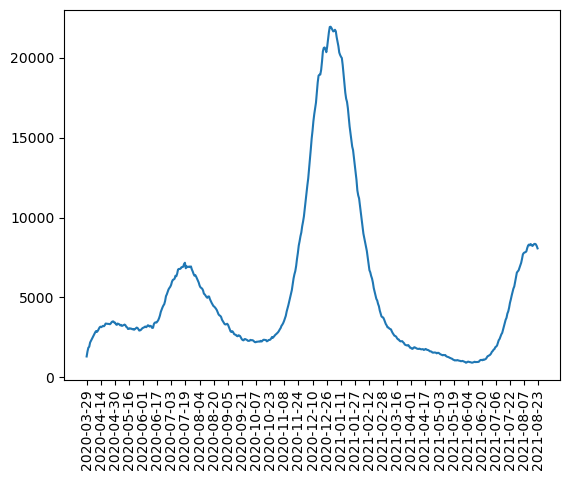

In [20]:
#### 引入一个实际案例看下
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## 案例信息准备并画图
df = pd.read_csv(r"D:\1-script\3-PYTHON\data存储jupyter用的个文件类型数据\Hands-On-Data-Preprocessing-in-Python-main\Chapter13\covid19hospitalbycounty.csv")
s1 = df.groupby(['todays_date']).hospitalized_covid_confirmed_patients.sum()
y = s1.values
xs = s1.index
plt.plot(xs,y)
plt.xticks(ticks = np.linspace(0,len(y), 33), labels = xs[0::16], rotation = 90)
plt.show()

------------------------
curve_fit 拟合系数为，[20815.4185175     89.84573064    29.80258346]

手动计算R2评价分数的结果为0.9726886779776469
------------------------
矩估计 拟合系数为，a1 = 21938.0,b1 = 88,c1 =26.326963906581742

手动计算R2评价分数的结果为0.9540612022875824
------------------------
三条钟型线拟合情况见下图


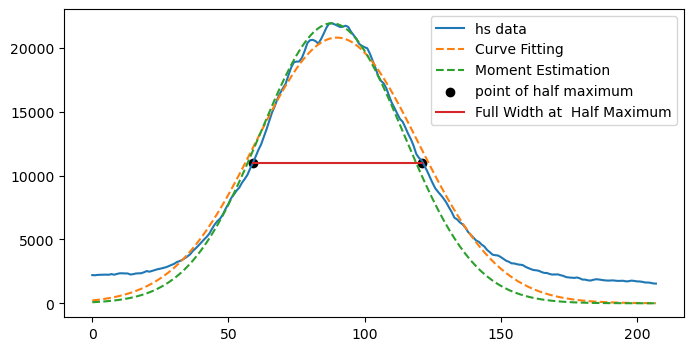

In [55]:
## 基于上面的画图 我们摘取 2020-10-10 到 2021-05-05 区间的大钟形状数据做一个拟合
def gaussian(x,a1,b1,c1):
    return a1 * np.exp(-((x - b1)**2) / (2 * c1**2))
    
s2 = s1['2020-10-10':'2021-05-05']
y = s2.values 
x = range(len(y))


## curve_fit 拟合 检查
p,c = curve_fit(gaussian,x,y)
y_predict = gaussian(x,*p)
RSS = np.sum( (y_predict - y) ** 2)
TSS =np.sum(  (y - y.mean())   **2)
R2 = 1 - RSS/TSS
print('------------------------')
print(f'curve_fit 拟合系数为，{p}')
print(f'\n手动计算R2评价分数的结果为{R2}')


## 也可以采取 矩估计 的办法 
# 直接采用 
a1 = y.max()      # y的最大值即位钟的顶端
b1 = np.argmax(y) # 峰值时x对应的值为多少  因 x-μ = 0 时取  y.max() ； 故而 峰值的x 等于y最大值对应的索引值
half_maximum = a1/2
left_index  =  np.where(y>= half_maximum)[0][0]
right_index =  np.where(y>= half_maximum)[0][-1]
Full_Width_Half_Maximum = right_index-left_index
c1 = Full_Width_Half_Maximum / 2.355  # 公式推到出的  Full_Width_Half_Maximum = sigma * 2.355
y_predict_2 = gaussian(x,a1,b1,c1)
RSS = np.sum( (y_predict_2 - y) ** 2)
TSS =np.sum(  (y - y.mean())   **2)
R2 = 1 - RSS/TSS
print('------------------------')
print(f'矩估计 拟合系数为，a1 = {a1},b1 = {b1},c1 ={c1}')
print(f'\n手动计算R2评价分数的结果为{R2}')


# 绘画
print('------------------------')
print('三条钟型线拟合情况见下图')
plt.figure(figsize = (8,4))
plt.plot(x,y,label = 'hs data')
plt.plot(x,y_predict,linestyle = '--' , label = 'Curve Fitting')
plt.plot(x,y_predict_2,linestyle = '--' , label = 'Moment Estimation')

plt.scatter(x = [left_index,right_index] , y = [ half_maximum,half_maximum],label = 'point of half maximum' ,c = 'black')
plt.plot([left_index,right_index] , [ half_maximum,half_maximum]  ,label = 'Full Width at  Half Maximum')
plt.legend()
plt.show()


In [41]:
plt.annotate??

Signature:
plt.annotate(
    text: 'str',
    xy: 'tuple[float, float]',
    xytext: 'tuple[float, float] | None' = None,
    xycoords: 'CoordsType' = 'data',
    textcoords: 'CoordsType | None' = None,
    arrowprops: 'dict[str, Any] | None' = None,
    annotation_clip: 'bool | None' = None,
    **kwargs,
) -> 'Annotation'
Docstring:
Annotate the point *xy* with text *text*.

In the simplest form, the text is placed at *xy*.

Optionally, the text can be displayed in another position *xytext*.
An arrow pointing from the text to the annotated point *xy* can then
be added by defining *arrowprops*.

Parameters
----------
text : str
    The text of the annotation.

xy : (float, float)
    The point *(x, y)* to annotate. The coordinate system is determined
    by *xycoords*.

xytext : (float, float), default: *xy*
    The position *(x, y)* to place the text at. The coordinate system
    is determined by *textcoords*.

xycoords : single or two-tuple of str or `.Artist` or `.Transform` or cal

In [28]:
y<= half_maximum

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,

In [30]:
half_maximum

10969.0

In [31]:
y

array([ 2209.,  2196.,  2226.,  2229.,  2239.,  2245.,  2234.,  2286.,
        2241.,  2291.,  2348.,  2351.,  2338.,  2336.,  2254.,  2281.,
        2334.,  2342.,  2358.,  2430.,  2525.,  2474.,  2537.,  2602.,
        2669.,  2712.,  2765.,  2821.,  2902.,  3001.,  3083.,  3224.,
        3300.,  3399.,  3531.,  3683.,  3852.,  4118.,  4309.,  4523.,
        4755.,  4989.,  5199.,  5459.,  5844.,  6188.,  6449.,  6647.,
        6972.,  7415.,  7787.,  8240.,  8517.,  8831.,  9065.,  9453.,
        9740., 10070., 10567., 11012., 11497., 12013., 12444., 13047.,
       13635., 14283., 14939., 15431., 16019., 16465., 16843., 17190.,
       17843., 18448., 18875., 18937., 18943., 19237., 19766., 20390.,
       20612., 20640., 20540., 20344., 20690., 21128., 21597., 21923.,
       21938., 21855., 21754., 21647., 21664., 21747., 21654., 21282.,
       20999., 20722., 20323., 20172., 20062., 19979., 19537., 18985.,
       18442., 17810., 17432., 17236., 16839., 16251., 15705., 15296.,
      

In [ ]:
np.linspace(0,len(y), 34,retstep=True)